## Import packages

In [141]:
# Data manipulation
import numpy as np
import pandas as pd
import glob, os
import time

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.ensemble import IsolationForest 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

## Preprocessing

#### Load files

In [143]:
# arkiv_B
path_arkivb = '/Users/Emil/Data/Exjobbsdata/Sandvik/Data/CSV_2018_B_Arkiv_Sekund'
all_arkivb = glob.glob(os.path.join(path_arkivb, "*.TXT")) #B1_2018_V21

df_each_arkivb = (pd.read_csv(f, sep=';', header = None, encoding = 'unicode_escape') for f in all_arkivb)
arkivb_df = pd.concat(df_each_arkivb, ignore_index = True)

arkivb_df['Datetime'] = pd.to_datetime(arkivb_df[3] + ' ' + arkivb_df[4])
arkivb_df = arkivb_df.drop([3, 4], axis = 1)

KeyError: '[3 4] not found in axis'

In [ ]:
# handelser (sep 17- jun 18)
path_handelser = '/Users/Emil/Data/Exjobbsdata/Sandvik/Data/Handelser'
all_handelser = glob.glob(os.path.join(path_handelser, "*.TXT"))

df_each_handelser = (pd.read_csv(f, sep=';', header = None, encoding = 'unicode_escape', parse_dates = [1]) for f in all_handelser)
handelser_df1 = pd.concat(df_each_handelser, ignore_index = True)
handelser_df = handelser_df.drop([3, 4], axis=1)

In [ ]:
# larm
#path_larm = '/Users/Emil/Data/Exjobbsdata/Sandvik/Data/Larm'
#all_larm = glob.glob(os.path.join(path_larm, "*.TXT"))

#df_each_larm = (pd.read_csv(f, sep=';', header = None, encoding = 'unicode_escape') for f in all_larm)
#larm_df = pd.concat(df_each_larm, ignore_index = True)

In [144]:
arkivb_df.shape

(197875932, 5)

#### Pivot data

In [ ]:
arkivb_pivot_df = pd.pivot_table(arkivb_df, values=0, index='Datetime', columns=2)

In [134]:
arkivb_pibvot_df.shape

(562364, 84)

#### Group by time

In [25]:
arkivb_grouped_df = arkivb_pivot_df.resample("3T").mean()
arkivb_grouped_df.shape

(3361, 84)

#### Erasing if variance is zero

In [26]:
# Drop columns with zero variance (constant)
cols_without_variance = [col for col in grouped_df.columns if (grouped_df[col].var() == 0)]
variance_df = grouped_df.drop(cols_without_variance, axis=1)

# Resulting shape
variance_df.shape

(3361, 73)

#### Handling missing values and imputing

In [27]:
# Specify acceptence percent of missing data
cut_off = 0.8 

# Drop columns with missing data
missing_df = variance_df.dropna(thresh = cut_off*len(variance_df.index), axis = 1)

# Impute missing values with linear function
imputed_df = missing_df.interpolate(axis=0)

# Resulting shape
missing_df.shape

(3361, 30)

#### Resulting dataframe

In [28]:
df = imputed_df
df.head()

2,"10AH.DRI: Drivning avhaspel, akt specifikt drag","11PAR.DRI: Drivning valspar 1, akt specifikt drag","11PAR.DRI: Drivning valspar 1, akt bandhastighet","12PAR.DRI: Drivning valspar 2, akt specifikt drag","13PAR.DRI: Drivning valspar 3, akt specifikt drag","14PH.DRI: Drivning påhaspel, akt specifikt drag","GIvare: Valsoljeflöde, skalat värde","Givare: Diametermätare avhaspel, skalat värde","Givare: Flöde från filter 1 till rentank, skalat värde","Givare: Flöde från filter 2 till rentank, skalat värde",...,"Givare:Temp valsolja, skalat värde",Hastighet par 3,Par 1: Diffvalskraft,Par 1: valskraft,Par 3: Diffvalskraft,Par 3: valskraft,"Posregulator valsspalt, ärvärde","Tjockleksmätare 1 , avvikelse","Tjockleksmätare 2 , avvikelse","Tjockleksmätare 3 , avvikelse"
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-05-21 01:00:00,0.0,0.600559,0.0,0.926163,0.0,0.878771,283.634545,185.455085,324.419512,327.753659,...,30.231818,0.0,0.0,0.0,-4.9,4.9,0.0,-186.4,-143.633333,-144.7
2018-05-21 01:03:00,0.0,0.635196,0.0,1.065363,0.0,0.929609,283.468142,185.251471,324.319178,327.750617,...,30.223404,0.0,0.0,0.0,-4.9,4.9,0.0,-186.4,-143.650000,-144.7
2018-05-21 01:06:00,0.0,0.650556,0.0,1.102222,0.0,0.970556,283.455263,185.323932,324.227027,327.780303,...,30.217647,0.0,0.0,0.0,-4.9,4.9,0.0,-186.4,-143.633333,-144.7
2018-05-21 01:09:00,0.0,0.658989,0.0,1.145506,0.0,0.990449,283.434951,185.386260,324.168919,327.752542,...,30.209677,0.0,0.0,0.0,-4.9,4.9,0.0,-186.4,-143.700000,-144.7
2018-05-21 01:12:00,0.0,0.648045,0.0,1.070391,0.0,0.967039,283.511864,185.664815,324.360294,327.891304,...,30.160000,0.0,0.0,0.0,-4.9,4.9,0.0,-186.4,-143.700000,-144.7


## Visualization

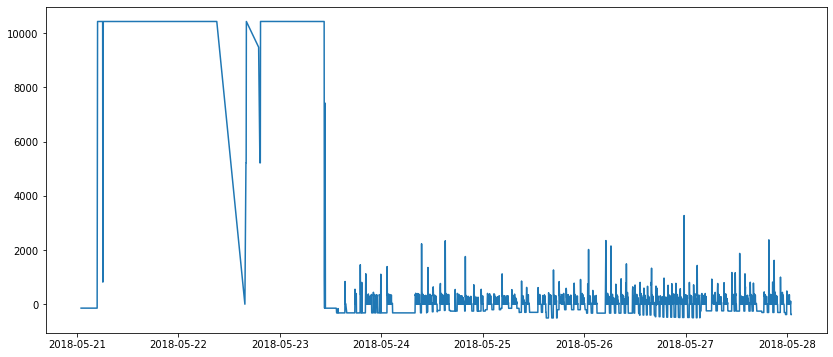

In [94]:
plt.figure(figsize=(14,6))
sns.lineplot(data = df['Tjockleksmätare 3 , avvikelse'])

## Model

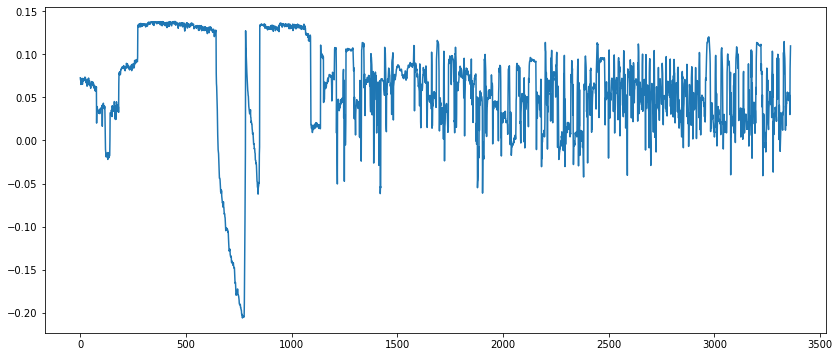

In [139]:
# Choose target and features
X = df
#y = # insert annotated data 
#train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

if_model = IsolationForest(contamination = 'auto', behaviour="new")
if_model.fit(X)
if_score = if_model.decision_function(X)

plt.figure(figsize=(14,6))
sns.lineplot(data = if_score)

In [140]:
handelser_df.head()

,0,1,2
0,HMI_AI._10AH_BG1041.STATUS,2017-09-01 01:48:36,Låg
1,HMI_AI._12TJM_BT1284_1.STATUS,2017-09-01 06:08:21,Låg
2,HMI_AI._12TJM_BT1284_1.STATUS,2017-09-01 07:51:42,Låg
3,HMI_AI._12TJM_BT1284_1.STATUS,2017-09-01 09:06:17,Låg
4,HMI_AI._12TJM_BT1284_1.STATUS,2017-09-01 10:21:16,Låg
